### Ver distribucion de randoms cuando defino la declinación cruda vs. arcsin(np.uniform(-1,1))

In [16]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
# Load galaxy data
zmin, zmax = 0.05, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]
ra = cat_sdss['ra'].values  # Right Ascension
dec = cat_sdss['dec'].values  # Declination

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 10 # Times the size of the data (around 10% is left after mask)

# Total number of pixels in the map
npix = hp.nside2npix(nside)

# Initialize a mask array (1 = valid, 0 = invalid)
mask = np.zeros(npix, dtype=int)

# Convert RA, Dec to Healpix indices
theta = np.radians(90 - dec)  # Declination to colatitude
phi = np.radians(ra)          # Right Ascension to longitude
pixels = hp.ang2pix(nside, theta, phi)

# Mark these pixels as valid
mask[pixels] = 1

num_randoms = len(ra)*nrand  # Number of random points

# Generate uniform random RA, Dec
ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
u = np.random.uniform(-1, 1, num_randoms)
dec_random_rad = np.arcsin(u)
dec_random1 = np.rad2deg(dec_random_rad)
dec_random2 = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

# Convert RA, Dec to Healpix indices
theta_random1 = np.radians(90 - dec_random1)
theta_random2 = np.radians(90 - dec_random2)
phi_random = np.radians(ra_random)
random_pixels1 = hp.ang2pix(nside, theta_random1, phi_random)
random_pixels2 = hp.ang2pix(nside, theta_random2, phi_random)

# Apply the mask
valid_indices1 = mask[random_pixels1] == 1
valid_indices2 = mask[random_pixels2] == 1
ra_random1 = ra_random[valid_indices1]
ra_random2 = ra_random[valid_indices2]
dec_random1 = dec_random1[valid_indices1]
dec_random2 = dec_random2[valid_indices2]

# Read redshift distribution and apply to randoms
# Build the inverse CDF from a smoothed KDE fit
cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(cat_sdss['red'], zmin, zmax)

# Generate random redshifts
#u = np.random.uniform(0, 1, len(ra_random))
#red_random = cdf_inv_z(u)

#random_data = pd.DataFrame({
#    'ra': ra_random,
#    'dec': dec_random,
#    'red': red_random
#})

#print(len(cat_sdss))
#print(len(random_data1))

#random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)


/home/federico/miniconda3/envs/nbodykit-env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


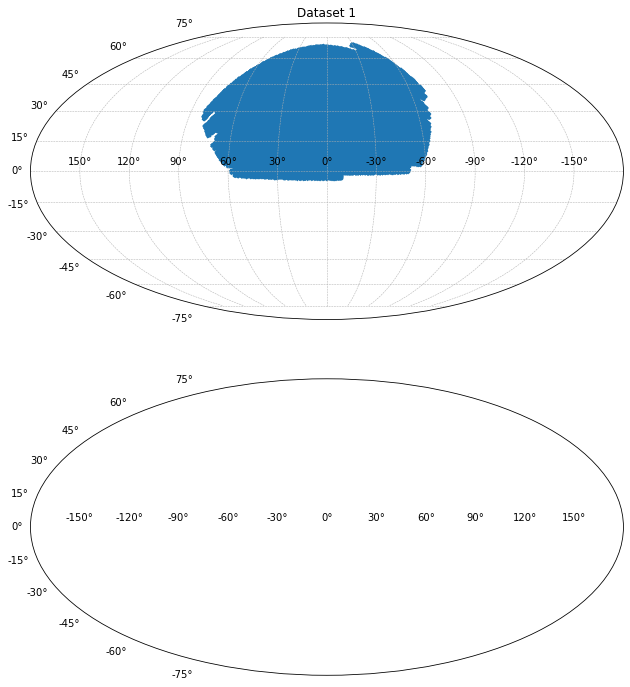

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mollweide(ax, ra, dec, title):
    """
    Plots a distribution of points in Mollweide projection.
    :param ax: Matplotlib axis object
    :param ra: Right Ascension in degrees (array-like)
    :param dec: Declination in degrees (array-like)
    :param title: Title for the subplot
    """
    # Convert RA to the range [-180, 180] and then to radians
    lon = -(np.array(ra) - 180) * np.pi / 180.0
    lat = np.array(dec) * np.pi / 180.0
    
    # Plot points
    ax.scatter(lon, lat, s=.1, color='C00', alpha=0.7)
    
    # Grid and labels
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '-30°', '-60°', '-90°', '-120°', '-150°'], 
                        fontsize=10)
    ax.set_title(title, fontsize=12)

fig, axes = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': 'mollweide'})
plot_mollweide(axes[0], ra_random, dec_random, "Dataset 1")
#plot_mollweide(axes[1], ra_random2, dec_random2, "Dataset 2")

plt.show()


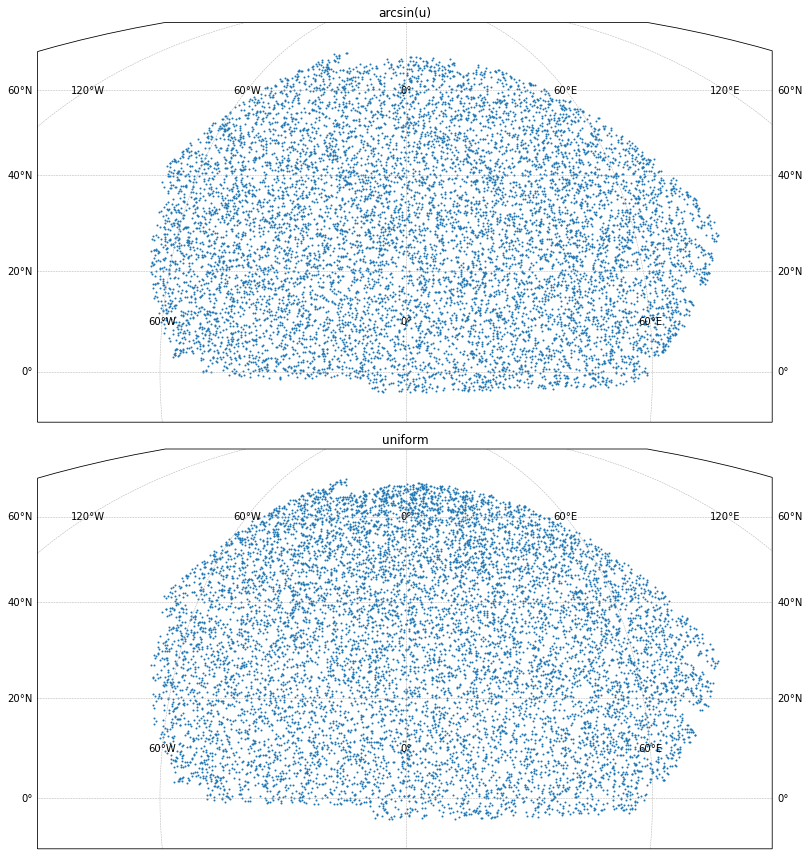

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_mollweide(ax, ra, dec, title, ra_min=0, ra_max=180, dec_min=-30, dec_max=30):
    """
    Plots a distribution of points in Mollweide projection with Cartopy, restricting the displayed region.
    :param ax: Matplotlib axis object
    :param ra: Right Ascension in degrees (array-like)
    :param dec: Declination in degrees (array-like)
    :param title: Title for the subplot
    :param ra_min: Minimum RA to display (degrees)
    :param ra_max: Maximum RA to display (degrees)
    :param dec_min: Minimum Dec to display (degrees)
    :param dec_max: Maximum Dec to display (degrees)
    """
    # Convert RA to longitude in degrees (RA [0,360] -> lon [-180,180])
    lon = np.array(ra) - 180
    lat = np.array(dec)
    
    # Mask points outside the desired region
    mask = (ra >= ra_min) & (ra <= ra_max) & (dec >= dec_min) & (dec <= dec_max)
    lon = lon[mask]
    lat = lat[mask]
    
    # Plot points
    ax.scatter(lon, lat, s=1, color='C00', alpha=1, transform=ccrs.PlateCarree())
    
    # Add gridlines and features
    ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    #ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
    ax.set_title(title, fontsize=12)
    
    # Limit the displayed region
    ax.set_extent([ra_min - 180, ra_max - 180, dec_min, dec_max], crs=ccrs.PlateCarree())

# Example usage: Random points
# total_points = 100
# ra_random1 = np.random.uniform(0, 360, total_points)
# dec_random1 = np.random.uniform(-90, 90, total_points)
# ra_random2 = np.random.uniform(0, 360, total_points)
# dec_random2 = np.random.uniform(-90, 90, total_points)

fig, axes = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': ccrs.Mollweide()})
plot_mollweide(axes[0], ra_random1[:10000], dec_random1[:10000], "arcsin(u)", ra_min=90, ra_max=270, dec_min=-10, dec_max=80)
plot_mollweide(axes[1], ra_random2[:10000], dec_random2[:10000], "uniform", ra_min=90, ra_max=270, dec_min=-10, dec_max=80)

plt.tight_layout()
plt.show()
